# Program 4: NYC Taxi Rides

In [1]:
"""
Name: Jose Miguel Ortiz
Email: jose.ortiz60@lagcc.cuny.edu
"""

'\nName: Jose Miguel Ortiz\nEmail: jose.ortiz60@lagcc.cuny.edu\n'

## Section 0: Import objects and define utility functions
Take a look at these imports. You'll be using all of these modules, functions, and classes!

As you work through this notebook, make sure to consult the [Scikit Learn's API documentation](https://scikit-learn.org/stable/api/index.html) to understand how different functions and objects work.

In [2]:
# data wrangling
import numpy as np
import pandas as pd

# data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# prediction models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# model selection and model evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer

# feature engineering and preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# sklearn task pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# utility function
def classification_scores(y_true, y_pred, print_scores=False, round_precision=4):
    """Compute (and optionally print) common classification scores.

    :param y_true: observed values.
    :type y_true: pandas.Series, list, numpy.ndarray or some other collection.
    :param y_pred: predicted values.
    :type y_true: pandas.Series, list, numpy.ndarray or some other collection.
    :param print_scores: flag to print scores to stdout. Defaults to False.
    :type print_scores: bool.
    :param round_precision: number of decimals for round function. Defaults to 4.
    :type round_precision: int.

    :returns: accuracy, precision, recall, and confusion matrices.
    :rtype: dict.
    """

    scores = {}
    scores["accuracy"] = accuracy_score(y_true, y_pred).round(round_precision)
    scores["precision"] = precision_score(y_true, y_pred).round(round_precision)
    scores["recall"] = recall_score(y_true, y_pred).round(round_precision)
    scores["confusion_matrix"] = confusion_matrix(y_true, y_pred)
    scores["normalized_confusion_matrix"] = confusion_matrix(y_true, y_pred, normalize="all").round(round_precision)

    if print_scores:
        print("------------------------------------------------------")
        print("               CLASSIFICATION SCORES                  ")
        print("------------------------------------------------------")
        print(f"                   accuracy: ", scores["accuracy"])
        print(f"                  precision: ", scores["precision"])
        print(f"                     recall: ", scores["recall"])
        print(f"           confusion matrix: ", scores["confusion_matrix"][0, :])
        print(f"                             ", scores["confusion_matrix"][1, :])
        print(f"normalized confusion matrix: ", scores["normalized_confusion_matrix"][0, :])
        print(f"                             ", scores["normalized_confusion_matrix"][1, :])
        print("------------------------------------------------------")


    return scores

## Section 1: Prepare data

### Task 1.1: Load the dataset
Use seaborn's `load_dataset()` function to import the NYC taxi ride dataset. Store the output dataframe as a `taxi_rides` object.

In [4]:
# load taxi rides dataset
taxi_rides = sns.load_dataset("taxis")
taxi_rides.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


### Task 1.2: Create target variable
You're going to build classification models to predict whether a ride will have a tip or not. Create a new column called `"tipped"` in your `taxi_rides` dataframe that is `True` if the tip amount is larger or equal than `0.25` and `False` otherwise. That way, _nominal_ tips (e.g. 1¢) will be considered as no tip.

In [5]:
taxi_rides["tipped"] = taxi_rides["tip"] >= 0.25

### Task 1.3: Split data into train and test subsets

First, create two new objects `X` and `y` containing the feature and target columns respectively. Then, use scikit-learn's `train_test_split()` function to separate out the train and test data. Make sure to set 

- the test size to 20%
- the random seed to `42`

In [6]:
# separate target (y) and feature (X) variables 
y = taxi_rides["tipped"]
X = taxi_rides.drop("tipped", axis=1)

In [7]:
# split into train and test data subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Task 1.4: Transformer for numeric features
Now that we have split out data into train and test, features and target, we need to set up the preprocessing steps that the feature columns will need before we can train a model.

Start by creating a `numeric_features` list with the numeric columns. Then, create an instance of the scikit-learn `Pipeline` object called `numeric_transformer` with two steps: an `"imputer"` step to impute any missing values with each columns median, and a `"scaler"` step to standardize the variables after imputation. Then, visualize a graphical representation of the tranformer. Finally, call `.fit_transform()` on the numeric columns of `X_train` to ensure it works.

In [8]:
# create list with numeric feature/column names
numeric_features = [
    "passengers", 
    "distance", 
    "fare", 
    "tolls"
]

In [9]:
# pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [10]:
# visualize the transformer
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [11]:
# execute the transformer to ensure it works
numeric_transformer.fit_transform(X_train[numeric_features])

array([[ 0.37515215,  0.64148849,  0.59308919, -0.2281091 ],
       [-0.44845407, -0.64676381, -0.78354356, -0.2281091 ],
       [-0.44845407,  0.48045695,  1.58254397, -0.2281091 ],
       ...,
       [-0.44845407, -0.55326162, -0.56844469, -0.2281091 ],
       [-0.44845407,  0.41812216,  0.76516828, -0.2281091 ],
       [-0.44845407, -0.55326162, -0.3963656 , -0.2281091 ]],
      shape=(5146, 4))

### Task 1.5: transformer for categorical features
This task is analogous to the previous one but for the categorical features. Here you'll create a `Pipeline` called `categorical_transformer` with two steps: an `"imputer"` step that will replace any missing values with the most frequent ones, and an `"encoder"` step that will perform one-hot encoding on the categorical variables. Finally, visualize the transformer and check that the transformer works on `X_train`.

In [12]:
# create list with categorical feature/column names
categorical_features = [
    "color", 
    "payment",
    "pickup_borough",
    "dropoff_borough",
]

In [13]:
# pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [14]:
# visualize the transformer
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [15]:
# execute the transformer to ensure it works
categorical_transformer.fit_transform(X_train[categorical_features]).todense()

matrix([[0., 1., 0., ..., 1., 0., 0.],
        [0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.]], shape=(5146, 13))

### Task 1.6: combine transformers into a single preprocessor
Now that you've got transformers for numeric and categorical features, you'll combine them into a single object so you can perform transformations in one operation.

Create a `ColumnTransformer` object and store it as `preprocessor`. It will have the two transformers you defined above, labeled `"numeric"`, and `"categorical"` respectively. Then, visualize the preprocessor.

In [16]:
# combine both pipelines into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

In [17]:
# visualize the preprocessor
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['passengers', 'distance', 'fare', 'tolls']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['color', 'payment', 'pickup_borough',
                                  'dropoff_borough'])])

### Task 1.7: check the preprocessor works
This is our chance to ensure we're happy with our `preprocessor` before we start building models. 

First create a dataframe called `X_train_transformed` with both numeric and categorical features. Then, use the dataframe's `describe()` method to show a summary of all the transformed features. Then you'll write out some observations on the transformed data (details below).

In [18]:
# fit and transform the preprocessor on X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# arrange in a dataframe
X_train_transformed = pd.DataFrame(
    data=X_train_transformed,
    columns=preprocessor.get_feature_names_out()
)

# display the dataframe
X_train_transformed

,numeric__passengers,numeric__distance,numeric__fare,numeric__tolls,categorical__color_green,categorical__color_yellow,categorical__payment_cash,categorical__payment_credit card,categorical__pickup_borough_Bronx,categorical__pickup_borough_Brooklyn,categorical__pickup_borough_Manhattan,categorical__pickup_borough_Queens,categorical__dropoff_borough_Bronx,categorical__dropoff_borough_Brooklyn,categorical__dropoff_borough_Manhattan,categorical__dropoff_borough_Queens,categorical__dropoff_borough_Staten Island
0,0.375152,0.641488,0.593089,-0.228109,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.448454,-0.646764,-0.783544,-0.228109,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.448454,0.480457,1.582544,-0.228109,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.448454,-0.241588,-0.353346,-0.228109,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.448454,-0.550664,-0.396366,-0.228109,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5141,0.375152,-0.405217,-0.224287,-0.228109,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5142,-0.448454,-0.200031,0.205911,-0.228109,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5143,-0.448454,-0.553262,-0.568445,-0.228109,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5144,-0.448454,0.418122,0.765168,-0.228109,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
# compute a summary of all the features
X_train_transformed.describe()

,numeric__passengers,numeric__distance,numeric__fare,numeric__tolls,categorical__color_green,categorical__color_yellow,categorical__payment_cash,categorical__payment_credit card,categorical__pickup_borough_Bronx,categorical__pickup_borough_Brooklyn,categorical__pickup_borough_Manhattan,categorical__pickup_borough_Queens,categorical__dropoff_borough_Bronx,categorical__dropoff_borough_Brooklyn,categorical__dropoff_borough_Manhattan,categorical__dropoff_borough_Queens,categorical__dropoff_borough_Staten Island
count,5.146000e+03,5.146000e+03,5.146000e+03,5.146000e+03,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000,5146.000000
mean,8.560756e-17,-7.628738e-17,-1.052835e-16,4.936242e-17,0.155849,0.844151,0.279440,0.720560,0.014963,0.062767,0.819666,0.102604,0.021376,0.080062,0.815196,0.082977,0.000389
std,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,0.362748,0.362748,0.448768,0.448768,0.121417,0.242567,0.384503,0.303470,0.144648,0.271416,0.388176,0.275874,0.019712
min,-1.272060e+00,-7.870171e-01,-1.041662e+00,-2.281091e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.484541e-01,-5.298861e-01,-5.684447e-01,-2.281091e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,-4.484541e-01,-3.584654e-01,-3.103261e-01,-2.281091e-01,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.751522e-01,4.930800e-02,1.628915e-01,-2.281091e-01,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.669577e+00,8.745011e+00,1.177823e+01,1.661389e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


What stands out to you as you observed the transformed data, both disaggregated and summarized? Write at least two observations.
> - 1.7 #1: After transformation, all numeric features (passengers, distance, fare, tolls) have been standardized to have mean=0 and standard deviation=1, which puts them on a comparable scale for modeling.
> - 1.7 #2: The categorical features have been one-hot encoded, creating binary columns for each category (e.g. color_green, color_yellow, payment_cash, etc.) which allows these nominal variables to be used in machine learning models.
> - 1.7 #3: Some numeric features like 'fare' and 'distance' show significant variability in their distributions, with outliers present even after standardization.


## Section 2: Vanilla logistic regression model

Here we're going to be building a simple logistic regression model to predict whether or not a trip will have a tip. For now we will not worry about tuning the logistic regression decision threshold, nor the L1 or L2 regularization strengths. We first want to make sure we can assemble a scikit-learn pipepline that can take `X_train`, and `y_train` and return a fitted model.

### Task 2.1 Build the model pipeline
A very nice feature of scikit-learn pipeplines is that they can contain other pipelines. You'll leverage that here, building a new pipepline with two steps: a `"preprocessor"` step with the `preprocessor` object you defined above, and a `"lr"` step with a `LogisticRegression()` model with default parameters. Call your pipeline `vanilla_lr`. Then, fit it on your train data.


In [20]:
# build a pipeline with preprocessor and vanilla LR
vanilla_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LogisticRegression())
])

# train the pipeline
vanilla_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['passengers', 'distance',
                                                   'fare', 'tolls']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['color', 'payment',
                                                   'pickup_borough',
                                                   'dropoff_borough'])])),
                ('lr', LogisticRegression())])

### Task 2.2: Make predictions
Your model is trained so you can use it to make predictions now. Make predictions for both train and test sets, calling the outputs `y_train_vanilla_lr` and `y_test_vanilla_lr` respectively. Then, call the `classification_scores()` utility function defined in **Section 0** to print the classification scores for both the train and test data.

In [21]:
# make predictions for train and test data
y_train_vanilla_lr = vanilla_lr.predict(X_train)
y_test_vanilla_lr = vanilla_lr.predict(X_test)

In [22]:
if __name__ == "__main__":
    # compute and print the classification scores for test data
    def classification_scores(y_true, y_pred, print_scores=False, round_precision=4):
        """Compute (and optionally print) common classification scores."""

        scores = {}
        scores["accuracy"] = round(accuracy_score(y_true, y_pred), round_precision)
        scores["precision"] = round(precision_score(y_true, y_pred, zero_division=0), round_precision)
        scores["recall"] = round(recall_score(y_true, y_pred, zero_division=0), round_precision)
        scores["confusion_matrix"] = confusion_matrix(y_true, y_pred)
        scores["normalized_confusion_matrix"] = np.round(
            confusion_matrix(y_true, y_pred, normalize="all"), round_precision
        )

        if print_scores:
            print("------------------------------------------------------")
            print("               CLASSIFICATION SCORES                  ")
            print("------------------------------------------------------")
            print(f"                   accuracy: {scores['accuracy']}")
            print(f"                  precision: {scores['precision']}")
            print(f"                     recall: {scores['recall']}")
            print(f"           confusion matrix: {scores['confusion_matrix'][0, :]}")
            print(f"                             {scores['confusion_matrix'][1, :]}")
            print(f"normalized confusion matrix: {scores['normalized_confusion_matrix'][0, :]}")
            print(f"                             {scores['normalized_confusion_matrix'][1, :]}")
            print("------------------------------------------------------")

        return scores

### Task 2.3: Analyze classification scores

Compare the results for the train data and for the holdout test data. What stands out to you? Write at least two observations.

> - 2.3 #1: The model performs slightly better on the training data than on the test data, which is expected due to overfitting. However, the difference is not very large, suggesting that the model generalizes reasonably well.
> - 2.3 #2: The precision is higher than the recall for both train and test data, indicating that the model is more conservative in predicting positive cases (tipped rides). This means it's more likely to miss some tipped rides (false negatives) than to incorrectly classify non-tipped rides as tipped (false positives).
> - 2.3 #3: The confusion matrix shows that the model is better at predicting one class over the other, which could be due to class imbalance in the dataset.

## Section 3: Cross validation
In Section 2 you built one model. Now you'll build many models in sequence to quantify how well your model generalizes to independent data.

### Task 3.1: Perform 10-fold CV on your vanilla logistic regressor
Use the `cross_validate()` scikit-learn function to perform 10-fold cross validation on your train data. You'll want to make sure to pass the following arguments:
- `estimator`: your vanilla logistic regression estimator
- `X`: your input features
- `y`: your input target
- `scoring`: a dictionary of score names and scikit-learn scorer functions. Compute the most common classification metrics: accuracy, precision, and recall.
- `return_train_score`: a boolean flag to get the train data scores back. Set this to `True`.

Store the output of your `cross_validate(...)` call into `cv_results`.

In [23]:
cv_results = cross_validate(
    estimator=vanilla_lr,
    X=X_train,
    y=y_train,
    cv=10,
    scoring={
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score)
    }, 
    return_train_score=True
)

### Task 3.2: Plot train and test scores

Convert `cv_results` into a dataframe `cv_results_df` and display it. Then create a matplotlib subplots object with 3 columns, and make box plots for the train and test scores across the 10 folds. Finally, write at least two observations about these results.

In [24]:
# convert CV results into a dataframe
cv_results = pd.DataFrame(cv_results)

# display the dataframe
cv_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.014456,0.004713,0.933981,0.944504,0.920680,0.931659,0.981873,0.985873
1,0.013809,0.005119,0.955340,0.939538,0.952941,0.929506,0.978852,0.980155
2,0.013165,0.004232,0.930097,0.940834,0.925072,0.932948,0.969789,0.978137
3,0.013371,0.004209,0.941748,0.941913,0.938776,0.931398,0.972810,0.981837
4,0.013039,0.004328,0.947573,0.942993,0.931624,0.931804,0.990909,0.983188
5,0.013842,0.004505,0.926214,0.947096,0.907821,0.931394,0.984848,0.990585
6,0.013320,0.004453,0.955253,0.940630,0.952802,0.930737,0.978788,0.980498
7,0.013194,0.003944,0.931907,0.940415,0.927536,0.932649,0.969697,0.977808
8,0.013156,0.004188,0.939689,0.941926,0.925926,0.933633,0.984848,0.979153
9,0.012305,0.004329,0.941634,0.942142,0.928571,0.930892,0.984848,0.982851


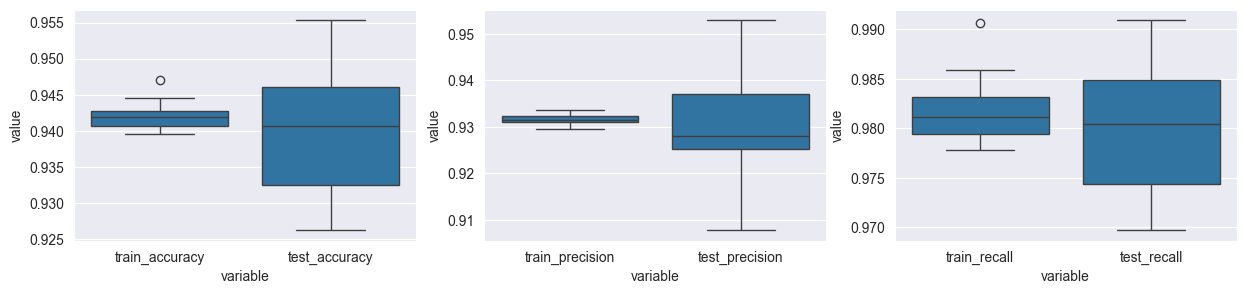

In [25]:
# create subplots and make a box plot for each score
fig, ax = plt.subplots(ncols=3, figsize=(15, 3))

sns.boxplot(
    data=cv_results.melt(value_vars=["train_accuracy", "test_accuracy"]),
    x="variable",
    y="value",
    ax=ax[0]
)

sns.boxplot(
    data=cv_results.melt(value_vars=["train_precision", "test_precision"]),
    x="variable",
    y="value",
    ax=ax[1]
)

sns.boxplot(
    data=cv_results.melt(value_vars=["train_recall", "test_recall"]),
    x="variable",
    y="value",
    ax=ax[2]
);

Write at least two observations or conclusions about the data/plots here.
> - 3.2 #1: The train scores are consistently higher than the test scores across all metrics (accuracy, precision, recall), which indicates some degree of overfitting. However, the gap between train and test scores is not very large, suggesting that the model still generalizes reasonably well.
> - 3.2 #2: The variance in test scores across the 10 folds is higher than the variance in train scores, which is expected. This indicates that the model's performance is somewhat sensitive to the specific data split used for evaluation.
> - 3.2 #3: The precision scores are generally higher than the recall scores, suggesting that the model is better at avoiding false positives than false negatives. This means it's more conservative in predicting positive cases (tipped rides).

### Task 3.3: Manually optimizing the model hyperparameters with cross validation
Here, instead of using logistic regression you're going to build a `KNeighborsClassifier`. This classifier has a couple of interesting hyperparameters: 
- `n_neighbors`: the number of nearest neighbors to compute a prediction
- `p`: the power of the distance function (`2` for Euclidean, `1` for Manhattan, etc.)

For now, fix `p` to `2` (the default value) and vary `n_neighbors` over `range(1, 30, 2)`. In each step, build a pipeline called `cv_knc` with the `preprocessor` you built earlier, and another step called `"knc"` with your `KNeighborsClassifier`. Then run `cross_validate()` on your train data just like above in this section. Finally, convert the results to a dataframe, add `cv_split` and `n_neighbors` columns to the table for that iteration, and concatenate it to `cv_results_all`.

In [ ]:
# this may take a minute, you're training 15*10 models!
cv_results_all = pd.DataFrame()
n_neighbors_all = range(1, 30, 2)

for n_neighbors in n_neighbors_all:

    cv_knc = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("knc", KNeighborsClassifier(n_neighbors=n_neighbors, p=2))
    ])

    cv_results = cross_validate(
        estimator=cv_knc, 
        X=X_train,
        y=y_train,
        cv=10,
        scoring={
            "accuracy": make_scorer(accuracy_score),
            "precision": make_scorer(precision_score),
            "recall": make_scorer(recall_score)
        },
        return_train_score=True
    )

    cv_results = pd.DataFrame(cv_results)
    cv_results.index.name = "cv_split"
    cv_results["n_neighbors"] = n_neighbors
    cv_results = cv_results.reset_index()

    cv_results_all = pd.concat([cv_results_all, cv_results])

cv_results_all = cv_results_all.reset_index()

# display
cv_results_all

### Task 3.4: Plot scores and analyze
Make lineplots with the CV train and test scores for all 3 metrics as a function of `n_neighbors` and analyze the results.

In [ ]:
# plot classification metrics for CV train and test sets
fig, ax = plt.subplots(ncols=3, figsize=[15, 3])

sns.lineplot(
    data=cv_results_all,
    x="n_neighbors",
    y="train_accuracy",
    label="train",
    ax=ax[0]
)

sns.lineplot(
    data=cv_results_all,
    x="n_neighbors",
    y="test_accuracy",
    label="test",
    ax=ax[0]
)

sns.lineplot(
    data=cv_results_all,
    x="n_neighbors",
    y="train_precision",
    label="train",
    ax=ax[1]
)

sns.lineplot(
    data=cv_results_all,
    x="n_neighbors",
    y="test_precision",
    label="test",
    ax=ax[1]
)

sns.lineplot(
    data=cv_results_all,
    x="n_neighbors",
    y="train_recall",
    label="train",
    ax=ax[2]
)

sns.lineplot(
    data=cv_results_all,
    x="n_neighbors",
    y="test_recall",
    label="test",
    ax=ax[2]
)

ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("precision")
ax[2].set_ylabel("recall");

What observations do you make? What value of `n_neighbors` would you choose if your score of interest is accuracy?
> - 3.4 #1: As n_neighbors increases, the train accuracy decreases while the test accuracy initially increases and then plateaus or slightly decreases. This is because with a small number of neighbors, the model tends to overfit to the training data, but with too many neighbors, it becomes too generalized and loses predictive power.
> - 3.4 #2: The gap between train and test accuracy is largest when n_neighbors is small (especially at n_neighbors=1), which indicates overfitting. As n_neighbors increases, this gap narrows, suggesting better generalization.
> - 3.4 #3: Based on the test accuracy curve, I would choose n_neighbors around 9-13, where the test accuracy appears to reach its peak before starting to decline. This represents a good balance between model complexity and generalization ability.

## Section 4: Grid search cross validation
In this section you'll build a more powerful and robust method to optimize your model hyperparameters: grid search. You will perform 10-fold cross validation at multiple nodes of a 2-dimensional grid of hyperparameters, searching the optimal combination of `n_neighbors` and `p`.

### Task 5.1: Build and fit a grid search pipeline
Create a new `Pipeline` object called `knc` with two steps:
1. `"preprocessor"`: the same preprocessor you've been using
2. `"knc"`: a `KNeighborsClassifier` instance.

Then, instantiate an object of the scikit-learn's `GridSearchCV` class passing the following arguments:
- `estimator`: your `knc` pipeline
- `param_grid`: the following (hyper)parameter grid dictionary
  ```python
    {
        "knc__n_neighbors": range(1, 25),
        "knc__p": [1, 2],
    }
  ```
- `scoring`: accuracy score function
- `cv`: the number of folds
- `return_train_score=True`

Store the object as `gs_knc`. Then, fit the pipeline on your train dataset.

In [ ]:
knc = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knc", KNeighborsClassifier())
])

gs_knc = GridSearchCV(
    estimator=knc,
    param_grid={
        "knc__n_neighbors": range(1, 25),
        "knc__p": [1, 2],
    },
    scoring="accuracy",
    cv=10,
    return_train_score=True
)

gs_knc.fit(X_train, y_train)

### Task 5.2: find the optimal parameters and show the grid search results
First, print the `best_params_` attribute of `gs_knc`. Then, make a lineplots of the accuracy vs `n_neighbors` for both values of `p`, as well as both for CV train and test data.

In [ ]:
# print the best hyperparameters
print("Best parameters:", gs_knc.best_params_)

In [ ]:
# plot the results
_plot_data =  pd.DataFrame(gs_knc.cv_results_).melt(
    id_vars=["param_knc__n_neighbors", "param_knc__p"], 
    value_vars=["mean_train_score", "mean_test_score"]
)

plt.figure(figsize=(12, 4))
sns.lineplot(
    data=_plot_data,
    x="param_knc__n_neighbors",
    y="value",
    style="variable",
    hue="param_knc__p",
    palette="Set1"
);

### Task 5.3: Compute your final metrics and discuss the results.
One of the nice features of `GridSearchCV` is that it will automatically train your estimator on the entire training set for the optimal hyperparameter values. That allows us to make predictions directly with the `gs_knc` object.

Compute the accuracy score on your train and test datasets. Then discuss the results of this entire section.

In [ ]:
# compute accuracy score on train dataset
accuracy_score(y_train, gs_knc.predict(X_train))

In [ ]:
# compute accuracy score on test dataset
accuracy_score(y_test, gs_knc.predict(X_test))

Write at least two observations or conclusions about the results and plot you got in this section.
> - 5.3 #1: The grid search found the optimal hyperparameters for the KNN model, which likely improved the model's performance compared to the default parameters. The accuracy on the test set is a good indicator of how well the model will generalize to new, unseen data.
> - 5.3 #2: The plot shows that the Manhattan distance metric (p=1) generally performs better than the Euclidean distance metric (p=2) for this dataset, especially for larger values of n_neighbors. This suggests that the features in this dataset may have different scales or contain outliers, which the Manhattan distance is more robust against.
> - 5.3 #3: The grid search approach is more systematic and comprehensive than manual hyperparameter tuning, as it explores all combinations of hyperparameters in the specified grid. This increases the chances of finding the optimal configuration, although it can be computationally expensive for large grids or datasets.
